# Backtesting Trader
- Used to generate the trade log (profit/loss)
- based on the a model's recommended action (forecast)
- and the price time-series

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sql

#### Combine Data 
- Combine forecasted data from models [Target	Prediction	Correct	% Buy	% Sell]
- With data from raw data (non-gaf) 

In [2]:
# Get Data 
conn = sql.connect('FX_data/database.db')
cur = conn.cursor()
df_results = pd.read_sql_query("SELECT * FROM LogisticRegression ",conn)
df_features = pd.read_sql_query("SELECT * FROM raw_prices WHERE Date >= '%s' AND Date <= '%s'"%(df_results.Date[0],df_results.Date[df_results.shape[0]-1]),conn)
df_features.drop(['Date'],axis=1,inplace=True)
df = pd.concat([df_results,df_features],axis=1)
df['Close'] = df['Price'] # duplibate for trader.One of the features will be scaled. 
df['Prob Buy'] = df['% Buy'] # duplibate for trader.One of the features will be scaled. 
df['Prob Sell'] = df['% Sell'] # duplibate for trader.One of the features will be scaled. 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'],inplace=True)
conn.close()

In [3]:
df.head(2)

,Target,Prediction,Correct,% Sell,% Buy,Price,Open,High,Low,Close,Prob Buy,Prob Sell
Date,,,,,,,,,,,,
2004-03-01,0,1,0,37.25,62.75,0.8034,0.8003,0.8048,0.7971,0.8034,62.75,37.25
2004-03-02,0,0,1,51.20,48.80,0.8184,0.8021,0.8201,0.8017,0.8184,48.80,51.20


#### Trader 

In [4]:
def classification_trader (balance, investment_size, prices,\
                        target,prediction,path,\
                        model_name,commission, dates ):
    """
    - Buy and Sell Trader agent 
    - For a single stock

    inputs: starting balance,position_size, df_labels, df_pred
    returns: print info and returns balance_tracker for plots 
    """
    trade_log = pd.DataFrame()
    # LOGS TO KEEP TRACK OF TRADER PERFORMANCE
    log = []; log_returns = []; log_profit = []; a =[]; ac=[]
    for today in range(prices.index.size):
        #break before end Sequence
        if today == len(prices.index)-1: break
        tomorrow = today + 1 
        # CLOSING PRICE
        today_close = prices[today]
        tomorrow_close =  prices[tomorrow]
        # PREDICTED ACTION FOR NEXT DAY
        d ={0:'NEUTRAL',1:'BUY',2:'SELL'}
        action = int(prediction[tomorrow])        # PREDICTIONS
        correct_action = int(target[tomorrow])    # TARGETS
        # DETERMINES HOW MANY SHARES CAN BE BOUGHT GIVEN INVESTMENT_SIZE
        position = investment_size / today_close

        print ('BOUGHT %s SHARES @ %s'%(np.round(position), np.round(today_close)))        
        """
        - Predict what position has to be taken 
        - See whether position has paid-off    
        """
        # BUY AGENT: PROFITS FROM APPRECIATION OF PRICE
        if action == 1: 
            ''' # makes buy only
            profit = 0
            achieved_returns = 0
            log.append(balance); log_profit.append(profit) ; log_returns.append(achieved_returns)
            '''
            achieved_returns = (tomorrow_close - today_close) # HOW MUCH SHARE PRICE ROSE
            profit = (achieved_returns)   * position # SHARE NUMBER * APPRECIATION
            transaction_cost = abs(profit)*commission # TRANSACTION COST
            profit = profit - transaction_cost
            balance += profit
            print('BOUGHT: profit: $%s, return: %s'%(int(profit),np.round(achieved_returns,3)))
            print('Commission: ',np.round(transaction_cost))
            if profit < 0: print( 'MISS__Should have been: %s'%(d[correct_action]))
            log.append(balance); log_profit.append(profit) ; log_returns.append(achieved_returns)
            a.append(action) ; ac.append(correct_action)
            print('CurrentBalance: ', int(balance), '\n') 
        # SELL AGENT: PROFITS FROM DEPRECIATION OF PRICE
        elif action == 0: 
            ''' # makes sell only
            profit = 0
            achieved_returns = 0
            log.append(balance); log_profit.append(profit) ; log_returns.append(achieved_returns)
            '''
            achieved_returns = (today_close - tomorrow_close)
            profit = (achieved_returns)    * position
            transaction_cost = abs(profit)*commission # TRANSACTION COST
            profit = profit - transaction_cost
            balance += profit
            print('SOLD: profit: $%s, return: %s'%(int(profit),np.round(achieved_returns,3)))
            print('Commission: ',np.round(transaction_cost))
            if profit < 0: print( 'MISS__Should have been: %s'%(d[correct_action]))
            log.append(balance); log_profit.append(profit) ; log_returns.append(achieved_returns)
            a.append(action) ; ac.append(correct_action)
            print('CurrentBalance: ',int(balance),'\n')                 
            
#         # NEUTRAL: NO PROFIT MADE
#         else: 
#             profit = 0
#             achieved_returns = 0
#             log.append(balance); log_profit.append(profit) ; log_returns.append(achieved_returns)
#             a.append(action) ; ac.append(correct_action)            
#             print('PASS', int(balance),'\n')

    trade_log['Date'] = dates
    trade_log['Balance'] = pd.Series(log)
    trade_log['Profit'] = pd.Series(log_profit)
    trade_log['Returns'] = pd.Series(log_returns)
    trade_log['Action'] = pd.Series(a)
    trade_log['Target'] = pd.Series(ac)
    
    trade_log.set_index('Date',inplace=True)
    # PROFIT PER DAY
    fig = plt.figure(figsize = (9,6))
    trade_log['Profit'].cumsum().plot() 
    plt.title('%s Profit'%(model_name))
    plt.savefig(path+'%s__Profit.png'%(model_name))
    plt.show()
    # ACHIEVED RETURNS 
    fig = plt.figure(figsize = (9,6))
    trade_log['Returns'].plot() 
    plt.title('%s Returns'%(model_name))
    plt.savefig(path+'%s__Returns.png'%(model_name))
    plt.show()
    # BALANCE
    fig = plt.figure(figsize = (9,6))
    trade_log['Balance'].plot()
    plt.title('%s Balance'%(model_name))
    plt.savefig(path+'%s__Balance.png'%(model_name))
    plt.show()
    return trade_log

In [5]:
def vizualize_trader_class (dates,prediction,price,df_trader,model_name,path):
    df.reset_index()['Date'], df['Prediction'], \
                       df['Price'], df_trading, \
                       model_name, path

    df_actions = pd.DataFrame()
    df_actions['Date'] = dates
    df_actions.set_index(['Date'],inplace=True)
    # IF PROBABILITIES PRESENT IN AXIS - DISCARD

    df_actions['Action'] = prediction
    #df_actions.reset_index(drop=True,inplace=True)

    buy_signals = prediction.reset_index().index[prediction == 1].to_list()
    sell_signals = prediction.reset_index().index[prediction == 0].to_list()
    end_balance = int(df_trader.Balance.dropna()[-1])
    gains = np.round((df_trader.Profit.sum() / df_trader.Balance[0])*100,2)


    fig = plt.figure(figsize = (18,10))
    ' INDEX'
    plt.plot(price, color='black', lw=2.)
    plt.plot(price, '^', markersize=3, color='g', label = 'BUY signal', markevery = buy_signals)
    plt.plot(price, 'v', markersize=3, color='r', label = 'SELL signal', markevery = sell_signals)
    plt.legend()
    plt.xlabel ('Backtest Period')
    plt.ylabel ('Exchange Price USD/EUR')
    plt.title('Trader: %s.  Final Balance %s. ROI %s%%'%(model_name,end_balance, gains))
    plt.savefig(path+'%s__Trades.png'%(model_name))
    plt.show()

#### Execute trading simulation

BOUGHT 6224.0 SHARES @ 1.0
SOLD: profit: $-96, return: -0.015
Commission:  3.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9903 

BOUGHT 6109.0 SHARES @ 1.0
BOUGHT: profit: $3, return: 0.001
Commission:  0.0
CurrentBalance:  9907 

BOUGHT 6105.0 SHARES @ 1.0
SOLD: profit: $-6, return: -0.001
Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9901 

BOUGHT 6098.0 SHARES @ 1.0
BOUGHT: profit: $-75, return: -0.012
Commission:  2.0
MISS__Should have been: BUY
CurrentBalance:  9825 

BOUGHT 6189.0 SHARES @ 1.0
BOUGHT: profit: $-10, return: -0.002
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9814 

BOUGHT 6201.0 SHARES @ 1.0
SOLD: profit: $-35, return: -0.006
Commission:  1.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9779 

BOUGHT 6158.0 SHARES @ 1.0
SOLD: profit: $-32, return: -0.005
Commission:  1.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9746 

BOUGHT 6120.0 SHARES @ 1.0
BOUGHT: profit: $-45, return: -0.007
Commission:  1.0
MISS__Should

SOLD: profit: $-2, return: -0.0
Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9421 

BOUGHT 6136.0 SHARES @ 1.0
BOUGHT: profit: $16, return: 0.003
Commission:  1.0
CurrentBalance:  9438 

BOUGHT 6115.0 SHARES @ 1.0
SOLD: profit: $-2, return: -0.0
Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9435 

BOUGHT 6112.0 SHARES @ 1.0
SOLD: profit: $11, return: 0.002
Commission:  0.0
CurrentBalance:  9447 

BOUGHT 6127.0 SHARES @ 1.0
BOUGHT: profit: $-49, return: -0.008
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  9397 

BOUGHT 6187.0 SHARES @ 1.0
BOUGHT: profit: $4, return: 0.001
Commission:  0.0
CurrentBalance:  9402 

BOUGHT 6180.0 SHARES @ 1.0
BOUGHT: profit: $2, return: 0.0
Commission:  0.0
CurrentBalance:  9405 

BOUGHT 6177.0 SHARES @ 1.0
SOLD: profit: $-6, return: -0.001
Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9398 

BOUGHT 6169.0 SHARES @ 1.0
SOLD: profit: $12, return: 0.002
Commission:  0.0
CurrentBalanc

Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9513 

BOUGHT 6685.0 SHARES @ 1.0
SOLD: profit: $7, return: 0.001
Commission:  0.0
CurrentBalance:  9521 

BOUGHT 6696.0 SHARES @ 1.0
BOUGHT: profit: $-45, return: -0.007
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  9475 

BOUGHT 6756.0 SHARES @ 1.0
SOLD: profit: $7, return: 0.001
Commission:  0.0
CurrentBalance:  9482 

BOUGHT 6766.0 SHARES @ 1.0
BOUGHT: profit: $-32, return: -0.005
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  9450 

BOUGHT 6808.0 SHARES @ 1.0
SOLD: profit: $-2, return: -0.0
Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9448 

BOUGHT 6805.0 SHARES @ 1.0
SOLD: profit: $-2, return: -0.0
Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9446 

BOUGHT 6803.0 SHARES @ 1.0
SOLD: profit: $12, return: 0.002
Commission:  0.0
CurrentBalance:  9459 

BOUGHT 6820.0 SHARES @ 1.0
SOLD: profit: $-31, return: -0.005
Commission:  1.0
MISS__Should have

CurrentBalance:  9311 

BOUGHT 6453.0 SHARES @ 1.0
BOUGHT: profit: $21, return: 0.003
Commission:  1.0
CurrentBalance:  9333 

BOUGHT 6424.0 SHARES @ 1.0
BOUGHT: profit: $-4, return: -0.001
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9329 

BOUGHT 6430.0 SHARES @ 1.0
SOLD: profit: $3, return: 0.001
Commission:  0.0
CurrentBalance:  9333 

BOUGHT 6435.0 SHARES @ 1.0
SOLD: profit: $-4, return: -0.001
Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9328 

BOUGHT 6429.0 SHARES @ 1.0
BOUGHT: profit: $-30, return: -0.005
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  9297 

BOUGHT 6467.0 SHARES @ 1.0
SOLD: profit: $13, return: 0.002
Commission:  0.0
CurrentBalance:  9311 

BOUGHT 6486.0 SHARES @ 1.0
BOUGHT: profit: $18, return: 0.003
Commission:  1.0
CurrentBalance:  9329 

BOUGHT 6462.0 SHARES @ 1.0
BOUGHT: profit: $2, return: 0.0
Commission:  0.0
CurrentBalance:  9332 

BOUGHT 6458.0 SHARES @ 1.0
SOLD: profit: $-44, return: -0.007
Commissi

Commission:  0.0
CurrentBalance:  9257 

BOUGHT 6148.0 SHARES @ 1.0
SOLD: profit: $-6, return: -0.001
Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9250 

BOUGHT 6139.0 SHARES @ 1.0
BOUGHT: profit: $18, return: 0.003
Commission:  1.0
CurrentBalance:  9268 

BOUGHT 6116.0 SHARES @ 1.0
BOUGHT: profit: $5, return: 0.001
Commission:  0.0
CurrentBalance:  9274 

BOUGHT 6109.0 SHARES @ 1.0
SOLD: profit: $49, return: 0.008
Commission:  2.0
CurrentBalance:  9323 

BOUGHT 6172.0 SHARES @ 1.0
BOUGHT: profit: $-65, return: -0.01
Commission:  2.0
MISS__Should have been: BUY
CurrentBalance:  9257 

BOUGHT 6252.0 SHARES @ 1.0
SOLD: profit: $8, return: 0.001
Commission:  0.0
CurrentBalance:  9266 

BOUGHT 6263.0 SHARES @ 1.0
BOUGHT: profit: $-6, return: -0.001
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9259 

BOUGHT 6270.0 SHARES @ 1.0
SOLD: profit: $-32, return: -0.005
Commission:  1.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9227 

BOUGHT 6231.0 SHARES

CurrentBalance:  9467 

BOUGHT 5935.0 SHARES @ 1.0
SOLD: profit: $2, return: 0.001
Commission:  0.0
CurrentBalance:  9470 

BOUGHT 5938.0 SHARES @ 1.0
SOLD: profit: $-12, return: -0.002
Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9458 

BOUGHT 5924.0 SHARES @ 1.0
BOUGHT: profit: $8, return: 0.001
Commission:  0.0
CurrentBalance:  9466 

BOUGHT 5914.0 SHARES @ 1.0
SOLD: profit: $2, return: 0.0
Commission:  0.0
CurrentBalance:  9468 

BOUGHT 5917.0 SHARES @ 1.0
SOLD: profit: $4, return: 0.001
Commission:  0.0
CurrentBalance:  9472 

BOUGHT 5922.0 SHARES @ 1.0
SOLD: profit: $0, return: 0.0
Commission:  0.0
CurrentBalance:  9473 

BOUGHT 5923.0 SHARES @ 1.0
BOUGHT: profit: $8, return: 0.002
Commission:  0.0
CurrentBalance:  9481 

BOUGHT 5912.0 SHARES @ 1.0
BOUGHT: profit: $-79, return: -0.013
Commission:  2.0
MISS__Should have been: BUY
CurrentBalance:  9402 

BOUGHT 6005.0 SHARES @ 1.0
BOUGHT: profit: $-50, return: -0.008
Commission:  1.0
MISS__Should have been: BUY

BOUGHT 6320.0 SHARES @ 1.0
SOLD: profit: $22, return: 0.004
Commission:  1.0
CurrentBalance:  9730 

BOUGHT 6348.0 SHARES @ 1.0
BOUGHT: profit: $-12, return: -0.002
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9718 

BOUGHT 6364.0 SHARES @ 1.0
SOLD: profit: $-8, return: -0.001
Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9709 

BOUGHT 6353.0 SHARES @ 1.0
SOLD: profit: $19, return: 0.003
Commission:  1.0
CurrentBalance:  9729 

BOUGHT 6379.0 SHARES @ 1.0
SOLD: profit: $12, return: 0.002
Commission:  0.0
CurrentBalance:  9741 

BOUGHT 6395.0 SHARES @ 1.0
SOLD: profit: $15, return: 0.003
Commission:  0.0
CurrentBalance:  9757 

BOUGHT 6416.0 SHARES @ 1.0
SOLD: profit: $38, return: 0.006
Commission:  1.0
CurrentBalance:  9795 

BOUGHT 6467.0 SHARES @ 1.0
BOUGHT: profit: $52, return: 0.008
Commission:  2.0
CurrentBalance:  9847 

BOUGHT 6399.0 SHARES @ 1.0
BOUGHT: profit: $-25, return: -0.004
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance: 

CurrentBalance:  10087 

BOUGHT 6347.0 SHARES @ 1.0
SOLD: profit: $18, return: 0.003
Commission:  1.0
CurrentBalance:  10105 

BOUGHT 6371.0 SHARES @ 1.0
BOUGHT: profit: $3, return: 0.0
Commission:  0.0
CurrentBalance:  10108 

BOUGHT 6367.0 SHARES @ 1.0
BOUGHT: profit: $-12, return: -0.002
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  10096 

BOUGHT 6382.0 SHARES @ 1.0
BOUGHT: profit: $3, return: 0.001
Commission:  0.0
CurrentBalance:  10099 

BOUGHT 6378.0 SHARES @ 1.0
SOLD: profit: $8, return: 0.001
Commission:  0.0
CurrentBalance:  10108 

BOUGHT 6389.0 SHARES @ 1.0
SOLD: profit: $-24, return: -0.004
Commission:  1.0
MISS__Should have been: NEUTRAL
CurrentBalance:  10084 

BOUGHT 6359.0 SHARES @ 1.0
BOUGHT: profit: $-1, return: -0.0
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  10082 

BOUGHT 6361.0 SHARES @ 1.0
SOLD: profit: $18, return: 0.003
Commission:  1.0
CurrentBalance:  10100 

BOUGHT 6386.0 SHARES @ 1.0
SOLD: profit: $-6, return: -0.001
Comm

CurrentBalance:  9881 

BOUGHT 6601.0 SHARES @ 1.0
SOLD: profit: $8, return: 0.001
Commission:  0.0
CurrentBalance:  9890 

BOUGHT 6613.0 SHARES @ 1.0
BOUGHT: profit: $-4, return: -0.001
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9885 

BOUGHT 6619.0 SHARES @ 1.0
SOLD: profit: $27, return: 0.004
Commission:  1.0
CurrentBalance:  9912 

BOUGHT 6657.0 SHARES @ 1.0
BOUGHT: profit: $5, return: 0.001
Commission:  0.0
CurrentBalance:  9918 

BOUGHT 6649.0 SHARES @ 1.0
SOLD: profit: $6, return: 0.001
Commission:  0.0
CurrentBalance:  9925 

BOUGHT 6658.0 SHARES @ 1.0
BOUGHT: profit: $-27, return: -0.004
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  9897 

BOUGHT 6693.0 SHARES @ 1.0
BOUGHT: profit: $20, return: 0.003
Commission:  1.0
CurrentBalance:  9917 

BOUGHT 6666.0 SHARES @ 1.0
BOUGHT: profit: $17, return: 0.003
Commission:  1.0
CurrentBalance:  9935 

BOUGHT 6642.0 SHARES @ 1.0
BOUGHT: profit: $-19, return: -0.003
Commission:  1.0
MISS__Should have bee

Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9787 

BOUGHT 6901.0 SHARES @ 1.0
BOUGHT: profit: $0, return: 0.0
Commission:  0.0
CurrentBalance:  9788 

BOUGHT 6900.0 SHARES @ 1.0
SOLD: profit: $9, return: 0.001
Commission:  0.0
CurrentBalance:  9798 

BOUGHT 6914.0 SHARES @ 1.0
SOLD: profit: $-5, return: -0.001
Commission:  0.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9792 

BOUGHT 6906.0 SHARES @ 1.0
BOUGHT: profit: $-6, return: -0.001
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9785 

BOUGHT 6915.0 SHARES @ 1.0
BOUGHT: profit: $37, return: 0.006
Commission:  1.0
CurrentBalance:  9823 

BOUGHT 6862.0 SHARES @ 1.0
BOUGHT: profit: $-7, return: -0.001
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9815 

BOUGHT 6872.0 SHARES @ 1.0
SOLD: profit: $-41, return: -0.006
Commission:  1.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9773 

BOUGHT 6817.0 SHARES @ 1.0
SOLD: profit: $20, return: 0.003
Commission:  1.0
CurrentBalance:  9

BOUGHT: profit: $29, return: 0.004
Commission:  1.0
CurrentBalance:  9755 

BOUGHT 7370.0 SHARES @ 1.0
SOLD: profit: $-37, return: -0.005
Commission:  1.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9717 

BOUGHT 7316.0 SHARES @ 1.0
BOUGHT: profit: $-12, return: -0.002
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9705 

BOUGHT 7334.0 SHARES @ 1.0
SOLD: profit: $32, return: 0.004
Commission:  1.0
CurrentBalance:  9737 

BOUGHT 7382.0 SHARES @ 1.0
BOUGHT: profit: $52, return: 0.007
Commission:  2.0
CurrentBalance:  9790 

BOUGHT 7302.0 SHARES @ 1.0
BOUGHT: profit: $-9, return: -0.001
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9780 

BOUGHT 7316.0 SHARES @ 1.0
SOLD: profit: $7, return: 0.001
Commission:  0.0
CurrentBalance:  9788 

BOUGHT 7328.0 SHARES @ 1.0
BOUGHT: profit: $-20, return: -0.003
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  9768 

BOUGHT 7357.0 SHARES @ 1.0
BOUGHT: profit: $21, return: 0.003
Commission:  1.0
CurrentB

BOUGHT 7849.0 SHARES @ 1.0
SOLD: profit: $40, return: 0.005
Commission:  1.0
CurrentBalance:  9446 

BOUGHT 7915.0 SHARES @ 1.0
SOLD: profit: $-27, return: -0.003
Commission:  1.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9418 

BOUGHT 7873.0 SHARES @ 1.0
SOLD: profit: $18, return: 0.002
Commission:  1.0
CurrentBalance:  9437 

BOUGHT 7903.0 SHARES @ 1.0
SOLD: profit: $12, return: 0.002
Commission:  0.0
CurrentBalance:  9449 

BOUGHT 7923.0 SHARES @ 1.0
BOUGHT: profit: $16, return: 0.002
Commission:  0.0
CurrentBalance:  9465 

BOUGHT 7896.0 SHARES @ 1.0
BOUGHT: profit: $-50, return: -0.006
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  9415 

BOUGHT 7974.0 SHARES @ 1.0
BOUGHT: profit: $15, return: 0.002
Commission:  0.0
CurrentBalance:  9430 

BOUGHT 7949.0 SHARES @ 1.0
BOUGHT: profit: $25, return: 0.003
Commission:  1.0
CurrentBalance:  9456 

BOUGHT 7908.0 SHARES @ 1.0
BOUGHT: profit: $-31, return: -0.004
Commission:  1.0
MISS__Should have been: BUY
CurrentBala

BOUGHT 7337.0 SHARES @ 1.0
SOLD: profit: $-23, return: -0.003
Commission:  1.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9269 

BOUGHT 7304.0 SHARES @ 1.0
BOUGHT: profit: $31, return: 0.004
Commission:  1.0
CurrentBalance:  9300 

BOUGHT 7257.0 SHARES @ 1.0
BOUGHT: profit: $7, return: 0.001
Commission:  0.0
CurrentBalance:  9308 

BOUGHT 7245.0 SHARES @ 1.0
SOLD: profit: $-89, return: -0.012
Commission:  3.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9218 

BOUGHT 7121.0 SHARES @ 1.0
BOUGHT: profit: $-8, return: -0.001
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9210 

BOUGHT 7134.0 SHARES @ 1.0
BOUGHT: profit: $47, return: 0.007
Commission:  1.0
CurrentBalance:  9257 

BOUGHT 7064.0 SHARES @ 1.0
BOUGHT: profit: $-2, return: -0.0
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9254 

BOUGHT 7068.0 SHARES @ 1.0
SOLD: profit: $-61, return: -0.008
Commission:  2.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9193 

BOUGHT 6985.0 SHARES @ 1.

Commission:  3.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9681 

BOUGHT 6803.0 SHARES @ 1.0
SOLD: profit: $-35, return: -0.005
Commission:  1.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9645 

BOUGHT 6756.0 SHARES @ 1.0
BOUGHT: profit: $-47, return: -0.007
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  9598 

BOUGHT 6818.0 SHARES @ 1.0
BOUGHT: profit: $-33, return: -0.005
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  9565 

BOUGHT 6862.0 SHARES @ 1.0
SOLD: profit: $-111, return: -0.016
Commission:  3.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9453 

BOUGHT 6717.0 SHARES @ 1.0
BOUGHT: profit: $22, return: 0.003
Commission:  1.0
CurrentBalance:  9475 

BOUGHT 6686.0 SHARES @ 1.0
SOLD: profit: $-68, return: -0.01
Commission:  2.0
MISS__Should have been: NEUTRAL
CurrentBalance:  9406 

BOUGHT 6598.0 SHARES @ 1.0
BOUGHT: profit: $11, return: 0.002
Commission:  0.0
CurrentBalance:  9418 

BOUGHT 6582.0 SHARES @ 1.0
BOUGHT: profit: $3, ret

BOUGHT 6997.0 SHARES @ 1.0
SOLD: profit: $6, return: 0.001
Commission:  0.0
CurrentBalance:  9001 

BOUGHT 7006.0 SHARES @ 1.0
BOUGHT: profit: $6, return: 0.001
Commission:  0.0
CurrentBalance:  9007 

BOUGHT 6996.0 SHARES @ 1.0
SOLD: profit: $-57, return: -0.008
Commission:  2.0
MISS__Should have been: NEUTRAL
CurrentBalance:  8950 

BOUGHT 6919.0 SHARES @ 1.0
SOLD: profit: $33, return: 0.005
Commission:  1.0
CurrentBalance:  8983 

BOUGHT 6967.0 SHARES @ 1.0
SOLD: profit: $75, return: 0.011
Commission:  2.0
CurrentBalance:  9058 

BOUGHT 7076.0 SHARES @ 1.0
SOLD: profit: $2, return: 0.0
Commission:  0.0
CurrentBalance:  9060 

BOUGHT 7079.0 SHARES @ 1.0
SOLD: profit: $50, return: 0.007
Commission:  2.0
CurrentBalance:  9111 

BOUGHT 7154.0 SHARES @ 1.0
BOUGHT: profit: $53, return: 0.008
Commission:  2.0
CurrentBalance:  9165 

BOUGHT 7076.0 SHARES @ 1.0
BOUGHT: profit: $-12, return: -0.002
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  9152 

BOUGHT 7093.0 SHARES @ 1.0

MISS__Should have been: NEUTRAL
CurrentBalance:  8973 

BOUGHT 7267.0 SHARES @ 1.0
SOLD: profit: $11, return: 0.002
Commission:  0.0
CurrentBalance:  8985 

BOUGHT 7285.0 SHARES @ 1.0
BOUGHT: profit: $-27, return: -0.004
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  8957 

BOUGHT 7325.0 SHARES @ 1.0
BOUGHT: profit: $-24, return: -0.003
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  8933 

BOUGHT 7359.0 SHARES @ 1.0
BOUGHT: profit: $10, return: 0.001
Commission:  0.0
CurrentBalance:  8944 

BOUGHT 7343.0 SHARES @ 1.0
BOUGHT: profit: $-35, return: -0.005
Commission:  1.0
MISS__Should have been: BUY
CurrentBalance:  8908 

BOUGHT 7394.0 SHARES @ 1.0
SOLD: profit: $-19, return: -0.003
Commission:  1.0
MISS__Should have been: NEUTRAL
CurrentBalance:  8888 

BOUGHT 7366.0 SHARES @ 1.0
BOUGHT: profit: $-14, return: -0.002
Commission:  0.0
MISS__Should have been: BUY
CurrentBalance:  8874 

BOUGHT 7387.0 SHARES @ 1.0
SOLD: profit: $25, return: 0.004
Commission:  

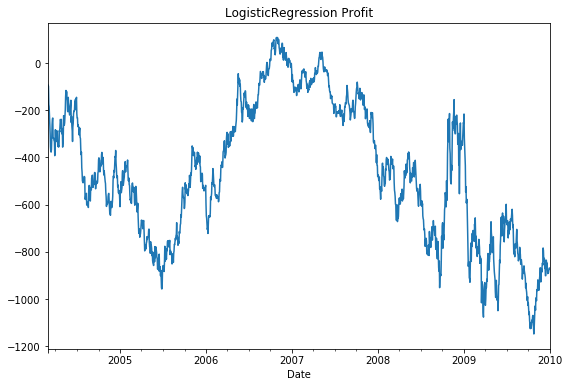

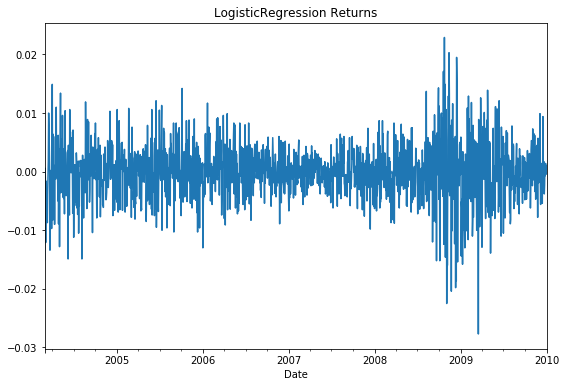

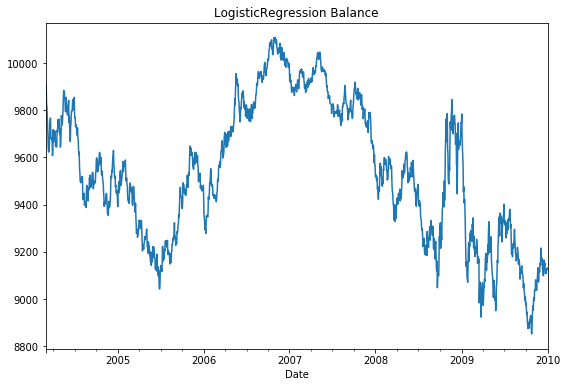

In [6]:
# SET PARAMETERS FOR TRADER
balance = 10000
investment_size = 5000 # TRADES DO NOT EXCEED A FEW HUNDREDS $  -
commission = 0.03 # % COMMISSION PER TRADE
path = 'images/trading_log'
model_name = 'LogisticRegression'
# TRADE
df_trading = classification_trader(balance, investment_size, df['Price'], \
                                df['Target'],df['Prediction'], path,\
                                model_name,commission, df.reset_index()['Date'] )

#### VISUALIZE TRADER ACTIONS ON PRICE GRAPH


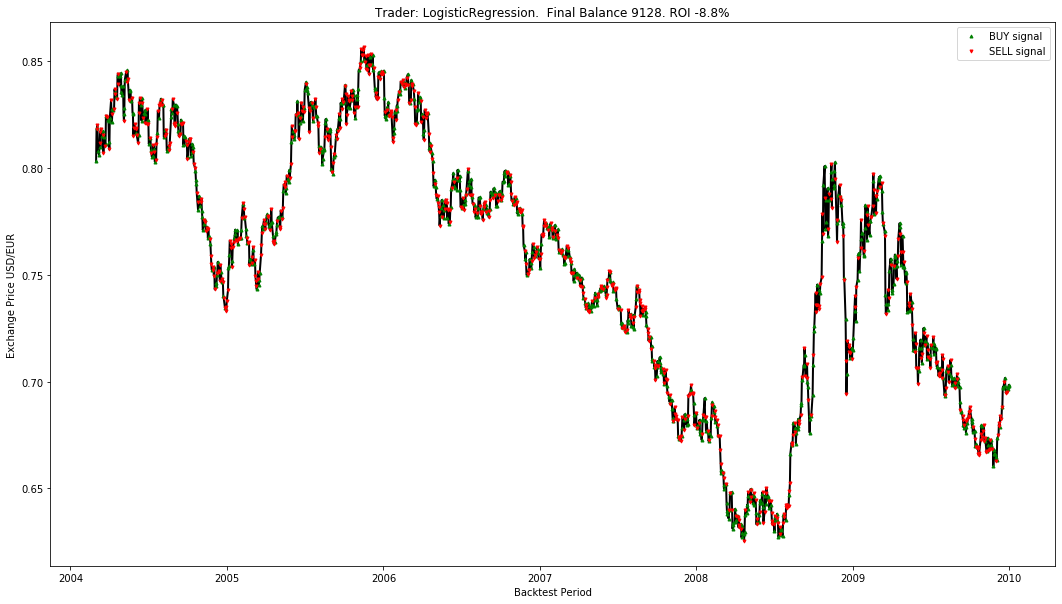

In [7]:
vizualize_trader_class(df.reset_index()['Date'], df['Prediction'], \
                       df['Price'], df_trading, \
                       model_name, path )

#### Combine trading log and save results 

In [8]:
df = pd.concat([df,df_trading[['Balance','Profit']]],axis=1)
df.head(2)

,Target,Prediction,Correct,% Sell,% Buy,Price,Open,High,Low,Close,Prob Buy,Prob Sell,Balance,Profit
Date,,,,,,,,,,,,,,
2004-03-01,0,1,0,37.25,62.75,0.8034,0.8003,0.8048,0.7971,0.8034,62.75,37.25,9903.846154,-96.153846
2004-03-02,0,0,1,51.20,48.80,0.8184,0.8021,0.8201,0.8017,0.8184,48.80,51.20,9907.401872,3.555718


In [9]:
conn = sql.connect('FX_data/database.db')
cur = conn.cursor()
df.to_sql("trade_log_%s"%(model_name),conn,if_exists='replace')
conn.close()

C:\Users\09ale\Anaconda3\lib\site-packages\pandas\core\generic.py:2712: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


=====================================   END   ===================================